## Task 1

- Importing Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import random

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import pickle
import json

- Function to Load the Test Embeddings

In [2]:
# Function to load the data from the json file
def load_from_json(file_path):
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

"""
Task 1 - Embeddings
"""
fasttext_task1 = "Task1_Fasttext_test_embeddings.pkl"
glove_task1 = "Task1_GLoVe_test_embeddings.pkl"
word2vec_task1 = "Task1_Word2Vec_test_embeddings.pkl"

# Load the embeddings
fasttext_embeddings = pickle.load(open(fasttext_task1, "rb"))
glove_embeddings = pickle.load(open(glove_task1, "rb"))
word2vec_embeddings = pickle.load(open(word2vec_task1, "rb"))

# Load the test labels
test_label_path = "NER_test_labels.json"
test_labels = load_from_json(test_label_path)

In [3]:
# Discard sentences with length greater than 174
fasttext_task1 = {k: v for k, v in fasttext_embeddings.items() if len(v) <= 174}
glove_task1 = {k: v for k, v in glove_embeddings.items() if len(v) <= 174}
word2vec_task1 = {k: v for k, v in word2vec_embeddings.items() if len(v) <= 174}

test_labels = {k: v for k, v in test_labels.items() if k in fasttext_task1}

- Padding the Sequences to the Same Length

In [4]:
max_length = 174

# Pad the embeddings
for key in fasttext_task1:
    label = test_labels[key]
    embeddings_fasttext = fasttext_task1[key]
    embeddings_glove = glove_task1[key]
    embeddings_word2vec = word2vec_task1[key]

    # Pad the labels
    if len(label) < max_length:
        label = label + ['O'] * (max_length - len(label))

    # Pad the embeddings
    if len(embeddings_fasttext) < max_length:
        embeddings_fasttext = np.concatenate((embeddings_fasttext, np.zeros((max_length - len(embeddings_fasttext), 300))), axis=0)
        embeddings_glove = np.concatenate((embeddings_glove, np.zeros((max_length - len(embeddings_glove), 300))), axis=0)
        embeddings_word2vec = np.concatenate((embeddings_word2vec, np.zeros((max_length - len(embeddings_word2vec), 300))), axis=0)

    # Update the 4 dictionaries
    fasttext_task1[key] = embeddings_fasttext
    glove_task1[key] = embeddings_glove
    word2vec_task1[key] = embeddings_word2vec
    test_labels[key] = label

# Iterate and check the length of the sentences
for key in test_labels:
    print(f"({len(test_labels[key])}, {len(test_labels[key][0])}), ({len(fasttext_task1[key])}, {len(fasttext_task1[key][0])}), ({len(glove_task1[key])}, {len(glove_task1[key][0])}), ({len(word2vec_task1[key])}, {len(word2vec_task1[key][0])})")

(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), (174, 300), (174, 300), (174, 300)
(174, 1), 

#### Labels to Index for all Models

In [5]:
"""
Task 1 - Labels to Index
"""

"""
RNN
"""
labels_to_index_rnn_fasttext = {'B_COURT': 0, 'I_GPE': 1, 'I_PROVISION': 2, 'B_ORG': 3, 'I_STATUTE': 4, 'I_RESPONDENT': 5, 'B_OTHER_PERSON': 6, 'B_CASE_NUMBER': 7, 'B_GPE': 8, 'B_PRECEDENT': 9, 'I_CASE_NUMBER': 10, 'I_OTHER_PERSON': 11, 'B_PROVISION': 12, 'B_JUDGE': 13, 'I_COURT': 14, 'I_JUDGE': 15, 'B_RESPONDENT': 16, 'B_WITNESS': 17, 'B_PETITIONER': 18, 'I_PETITIONER': 19, 'I_PRECEDENT': 20, 'I_WITNESS': 21, 'I_ORG': 22, 'O': 23, 'B_STATUTE': 24, 'I_DATE': 25, 'B_DATE': 26}
labels_to_index_rnn_glove = {'I_OTHER_PERSON': 0, 'I_DATE': 1, 'I_ORG': 2, 'B_WITNESS': 3, 'B_OTHER_PERSON': 4, 'B_PETITIONER': 5, 'I_STATUTE': 6, 'B_PRECEDENT': 7, 'B_ORG': 8, 'I_PROVISION': 9, 'I_WITNESS': 10, 'B_GPE': 11, 'B_DATE': 12, 'I_COURT': 13, 'I_PRECEDENT': 14, 'B_PROVISION': 15, 'B_RESPONDENT': 16, 'I_RESPONDENT': 17, 'B_JUDGE': 18, 'B_COURT': 19, 'I_JUDGE': 20, 'I_GPE': 21, 'B_STATUTE': 22, 'O': 23, 'I_CASE_NUMBER': 24, 'B_CASE_NUMBER': 25, 'I_PETITIONER': 26}
labels_to_index_rnn_word2vec = {'I_RESPONDENT': 0, 'B_PRECEDENT': 1, 'I_PRECEDENT': 2, 'I_ORG': 3, 'I_COURT': 4, 'I_JUDGE': 5, 'B_ORG': 6, 'B_DATE': 7, 'I_GPE': 8, 'B_OTHER_PERSON': 9, 'B_RESPONDENT': 10, 'I_STATUTE': 11, 'I_DATE': 12, 'I_CASE_NUMBER': 13, 'I_PETITIONER': 14, 'B_WITNESS': 15, 'B_JUDGE': 16, 'B_CASE_NUMBER': 17, 'B_PETITIONER': 18, 'I_OTHER_PERSON': 19, 'O': 20, 'B_STATUTE': 21, 'I_PROVISION': 22, 'I_WITNESS': 23, 'B_GPE': 24, 'B_PROVISION': 25, 'B_COURT': 26}


"""
LSTM
"""
labels_to_index_lstm_fasttext = {'B_GPE': 0, 'I_ORG': 1, 'I_PRECEDENT': 2, 'I_COURT': 3, 'I_WITNESS': 4, 'B_DATE': 5, 'I_CASE_NUMBER': 6, 'B_ORG': 7, 'I_DATE': 8, 'I_OTHER_PERSON': 9, 'B_PROVISION': 10, 'B_CASE_NUMBER': 11, 'I_GPE': 12, 'I_RESPONDENT': 13, 'B_JUDGE': 14, 'I_JUDGE': 15, 'B_PRECEDENT': 16, 'B_PETITIONER': 17, 'I_PROVISION': 18, 'B_OTHER_PERSON': 19, 'B_STATUTE': 20, 'B_RESPONDENT': 21, 'I_PETITIONER': 22, 'B_WITNESS': 23, 'B_COURT': 24, 'O': 25, 'I_STATUTE': 26}
labels_to_index_lstm_glove = {'B_JUDGE': 0, 'B_PRECEDENT': 1, 'I_STATUTE': 2, 'B_WITNESS': 3, 'B_ORG': 4, 'I_PETITIONER': 5, 'B_CASE_NUMBER': 6, 'I_GPE': 7, 'B_OTHER_PERSON': 8, 'I_COURT': 9, 'B_DATE': 10, 'I_WITNESS': 11, 'B_PETITIONER': 12, 'I_DATE': 13, 'I_PRECEDENT': 14, 'I_CASE_NUMBER': 15, 'B_GPE': 16, 'B_COURT': 17, 'I_OTHER_PERSON': 18, 'B_RESPONDENT': 19, 'O': 20, 'I_ORG': 21, 'I_JUDGE': 22, 'I_RESPONDENT': 23, 'B_STATUTE': 24, 'I_PROVISION': 25, 'B_PROVISION': 26}
labels_to_index_lstm_word2vec = {'I_OTHER_PERSON': 0, 'I_WITNESS': 1, 'B_RESPONDENT': 2, 'B_OTHER_PERSON': 3, 'B_STATUTE': 4, 'B_COURT': 5, 'I_ORG': 6, 'I_CASE_NUMBER': 7, 'I_DATE': 8, 'B_PRECEDENT': 9, 'B_PETITIONER': 10, 'B_DATE': 11, 'I_STATUTE': 12, 'I_PETITIONER': 13, 'B_ORG': 14, 'B_CASE_NUMBER': 15, 'I_COURT': 16, 'I_PRECEDENT': 17, 'I_PROVISION': 18, 'I_RESPONDENT': 19, 'B_GPE': 20, 'I_GPE': 21, 'O': 22, 'B_PROVISION': 23, 'I_JUDGE': 24, 'B_JUDGE': 25, 'B_WITNESS': 26}

"""
GRU
"""
labels_to_index_gru_fasttext = {'I_OTHER_PERSON': 0, 'B_WITNESS': 1, 'B_JUDGE': 2, 'I_WITNESS': 3, 'B_COURT': 4, 'I_STATUTE': 5, 'B_CASE_NUMBER': 6, 'I_PRECEDENT': 7, 'I_CASE_NUMBER': 8, 'I_RESPONDENT': 9, 'B_GPE': 10, 'I_ORG': 11, 'O': 12, 'B_ORG': 13, 'I_GPE': 14, 'B_DATE': 15, 'I_PROVISION': 16, 'I_JUDGE': 17, 'B_RESPONDENT': 18, 'I_DATE': 19, 'B_STATUTE': 20, 'B_PROVISION': 21, 'B_OTHER_PERSON': 22, 'B_PETITIONER': 23, 'B_PRECEDENT': 24, 'I_PETITIONER': 25, 'I_COURT': 26}
labels_to_index_gru_glove = {'I_COURT': 0, 'B_ORG': 1, 'I_DATE': 2, 'I_ORG': 3, 'I_STATUTE': 4, 'B_COURT': 5, 'B_CASE_NUMBER': 6, 'I_CASE_NUMBER': 7, 'B_PROVISION': 8, 'O': 9, 'B_PRECEDENT': 10, 'I_PROVISION': 11, 'B_RESPONDENT': 12, 'B_OTHER_PERSON': 13, 'I_WITNESS': 14, 'I_PRECEDENT': 15, 'I_JUDGE': 16, 'I_RESPONDENT': 17, 'B_PETITIONER': 18, 'B_WITNESS': 19, 'B_GPE': 20, 'B_DATE': 21, 'I_GPE': 22, 'I_OTHER_PERSON': 23, 'I_PETITIONER': 24, 'B_STATUTE': 25, 'B_JUDGE': 26}
labels_to_index_gru_word2vec = {'O': 0, 'B_ORG': 1, 'B_STATUTE': 2, 'B_OTHER_PERSON': 3, 'I_PROVISION': 4, 'I_DATE': 5, 'I_WITNESS': 6, 'I_OTHER_PERSON': 7, 'B_JUDGE': 8, 'B_DATE': 9, 'I_PETITIONER': 10, 'B_COURT': 11, 'I_GPE': 12, 'I_JUDGE': 13, 'B_WITNESS': 14, 'B_RESPONDENT': 15, 'I_RESPONDENT': 16, 'I_PRECEDENT': 17, 'B_PETITIONER': 18, 'I_CASE_NUMBER': 19, 'B_PROVISION': 20, 'B_CASE_NUMBER': 21, 'I_STATUTE': 22, 'B_GPE': 23, 'B_PRECEDENT': 24, 'I_COURT': 25, 'I_ORG': 26}

"""
BiLSTM-CRF
"""
labels_to_index_bilstmcrf_word2vec = {'I_RESPONDENT': 0, 'I_PROVISION': 1, 'B_PROVISION': 2, 'B_STATUTE': 3, 'B_CASE_NUMBER': 4, 'I_STATUTE': 5, 'B_COURT': 6, 'B_PETITIONER': 7, 'B_PRECEDENT': 8, 'B_RESPONDENT': 9, 'B_ORG': 10, 'I_COURT': 11, 'I_CASE_NUMBER': 12, 'B_WITNESS': 13, 'I_WITNESS': 14, 'I_GPE': 15, 'I_JUDGE': 16, 'B_GPE': 17, 'B_JUDGE': 18, 'I_ORG': 19, 'B_DATE': 20, 'I_DATE': 21, 'I_PETITIONER': 22, 'O': 23, 'I_PRECEDENT': 24, 'B_OTHER_PERSON': 25, 'I_OTHER_PERSON': 26}
labels_to_index_bilstmcrf_glove = {'I_PRECEDENT': 0, 'O': 1, 'B_COURT': 2, 'I_JUDGE': 3, 'B_OTHER_PERSON': 4, 'I_PROVISION': 5, 'B_CASE_NUMBER': 6, 'I_COURT': 7, 'B_ORG': 8, 'I_STATUTE': 9, 'I_CASE_NUMBER': 10, 'B_GPE': 11, 'I_GPE': 12, 'I_OTHER_PERSON': 13, 'I_RESPONDENT': 14, 'B_PROVISION': 15, 'B_PRECEDENT': 16, 'B_DATE': 17, 'B_WITNESS': 18, 'B_STATUTE': 19, 'I_ORG': 20, 'B_JUDGE': 21, 'B_RESPONDENT': 22, 'I_DATE': 23, 'B_PETITIONER': 24, 'I_PETITIONER': 25, 'I_WITNESS': 26}
labels_to_index_bilstmcrf_fasttext = {'B_PRECEDENT': 0, 'I_PROVISION': 1, 'I_ORG': 2, 'B_ORG': 3, 'B_CASE_NUMBER': 4, 'I_WITNESS': 5, 'B_OTHER_PERSON': 6, 'I_OTHER_PERSON': 7, 'B_WITNESS': 8, 'B_PETITIONER': 9, 'I_STATUTE': 10, 'B_RESPONDENT': 11, 'I_GPE': 12, 'I_CASE_NUMBER': 13, 'O': 14, 'I_RESPONDENT': 15, 'B_GPE': 16, 'B_STATUTE': 17, 'B_DATE': 18, 'I_PRECEDENT': 19, 'I_PETITIONER': 20, 'B_COURT': 21, 'B_JUDGE': 22, 'I_JUDGE': 23, 'B_PROVISION': 24, 'I_DATE': 25, 'I_COURT': 26}

In [6]:
def labels_to_indices(labels, label_to_index):
    return [[label_to_index[label] for label in sentence_labels] for sentence_labels in labels]

# Convert the labels to indices
test_labels_rnn_fasttext = labels_to_indices(test_labels.values(), labels_to_index_rnn_fasttext)
test_labels_rnn_glove = labels_to_indices(test_labels.values(), labels_to_index_rnn_glove)
test_labels_rnn_word2vec = labels_to_indices(test_labels.values(), labels_to_index_rnn_word2vec)

#### Converting to Tensors and Dataloaders for RNN

In [7]:
# Convert to tensor
embeddings_fasttext_tensor = torch.tensor([fasttext_task1[key] for key in test_labels], dtype=torch.float)
embeddings_glove_tensor = torch.tensor([glove_task1[key] for key in test_labels], dtype=torch.float)
embeddings_word2vec_tensor = torch.tensor([word2vec_task1[key] for key in test_labels], dtype=torch.float)

# Get label tensors for RNN
test_labels_rnn_fasttext_tensor = torch.tensor(test_labels_rnn_fasttext, dtype=torch.long)
test_labels_rnn_glove_tensor = torch.tensor(test_labels_rnn_glove, dtype=torch.long)
test_labels_rnn_word2vec_tensor = torch.tensor(test_labels_rnn_word2vec, dtype=torch.long)

"""
Dataloaders for RNN
"""
test_dataset_fasttext = TensorDataset(embeddings_fasttext_tensor, test_labels_rnn_fasttext_tensor)
test_dataloader_fasttext_rnn = DataLoader(test_dataset_fasttext, batch_size=32, shuffle=False)

test_dataset_glove = TensorDataset(embeddings_glove_tensor, test_labels_rnn_glove_tensor)
test_dataloader_glove_rnn = DataLoader(test_dataset_glove, batch_size=32, shuffle=False)

test_dataset_word2vec = TensorDataset(embeddings_word2vec_tensor, test_labels_rnn_word2vec_tensor)
test_dataloader_word2ve_rnn = DataLoader(test_dataset_word2vec, batch_size=32, shuffle=False)

/var/folders/c9/s8062nf53sv0b6gfv3ct0lv80000gn/T/ipykernel_38715/22124876.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  embeddings_fasttext_tensor = torch.tensor([fasttext_task1[key] for key in test_labels], dtype=torch.float)


In [8]:
# Iterate through dataloaders to check the shape of the data
for i, (x, y) in enumerate(test_dataloader_fasttext_rnn):
    print(x.shape, y.shape)
    break

torch.Size([32, 174, 300]) torch.Size([32, 174])


### Task 1 - RNN

In [9]:
class FasttextRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(FasttextRNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out
    
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

In [10]:
"""
For Word2Vec
"""
model_word2vec_rnn_task1 = RNNModel(input_dim=300, hidden_dim=256, output_dim=27, num_layers=1)

# Load the model
model_word2vec_rnn_task1.load_state_dict(torch.load("Task1_RNN_Word2Vec_model.pth"))

# Set the model to evaluation mode
model_word2vec_rnn_task1.eval()

# Evaluation
test_preds_rnn_word2vec_task1 = []
test_true_rnn_word2vec_task1 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_word2ve_rnn:
        outputs = model_word2vec_rnn_task1(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_rnn_word2vec_task1 .extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_rnn_word2vec_task1.extend(labels.view(-1).numpy())  # Flatten and store true labels

# Calculate the F1-score
f1_score_rnn_word2vec_task1 = f1_score(test_true_rnn_word2vec_task1, test_preds_rnn_word2vec_task1, average='macro')

# Calculate the accuracy
accuracy_rnn_word2vec_task1 = accuracy_score(test_true_rnn_word2vec_task1, test_preds_rnn_word2vec_task1)

print(f"Task1 - RNN Word2Vec - F1: {f1_score_rnn_word2vec_task1}")
print(f"Task1 - RNN Word2Vec - Accuracy: {accuracy_rnn_word2vec_task1}")

Task1 - RNN Word2Vec - F1: 0.4389956021286754
Task1 - RNN Word2Vec - Accuracy: 0.9813870783721128


In [11]:
"""
For GLoVe
"""
model_glove_rnn_task1 = RNNModel(input_dim=300, hidden_dim=256, output_dim=27, num_layers=1)

# Load the model
model_glove_rnn_task1.load_state_dict(torch.load("Task1_RNN_GloVe_model.pth"))

# Set the model to evaluation mode
model_glove_rnn_task1.eval()

# Evaluation
test_preds_rnn_glove_task1 = []
test_true_rnn_glove_task1 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_glove_rnn:
        outputs = model_glove_rnn_task1(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_rnn_glove_task1.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_rnn_glove_task1.extend(labels.view(-1).numpy())

# Calculate the F1-score
f1_score_rnn_glove_task1 = f1_score(test_true_rnn_glove_task1, test_preds_rnn_glove_task1, average='macro')

# Calculate the accuracy
accuracy_rnn_glove_task1 = accuracy_score(test_true_rnn_glove_task1, test_preds_rnn_glove_task1)

print(f"Task1 - RNN GLoVe - F1: {f1_score_rnn_glove_task1}")
print(f"Task1 - RNN GLoVe - Accuracy: {accuracy_rnn_glove_task1}")

Task1 - RNN GLoVe - F1: 0.5291016245424054
Task1 - RNN GLoVe - Accuracy: 0.9854470863828909


In [12]:
"""
For Fasttext

"""

model_fasttext_rnn_task1 = FasttextRNNModel(input_dim=300, hidden_dim=128, output_dim=27, num_layers=1)

# Load the model
model_fasttext_rnn_task1.load_state_dict(torch.load("Task1_RNN_FastText_model.pth"))

# Set the model to evaluation mode
model_fasttext_rnn_task1.eval()

# Evaluation
test_preds_rnn_fasttext_task1 = []
test_true_rnn_fasttext_task1 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_fasttext_rnn:
        outputs = model_fasttext_rnn_task1(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_rnn_fasttext_task1.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_rnn_fasttext_task1.extend(labels.view(-1).numpy())

# Calculate the F1-score
f1_score_rnn_fasttext_task1 = f1_score(test_true_rnn_fasttext_task1, test_preds_rnn_fasttext_task1, average='macro')

# Calculate the accuracy
accuracy_rnn_fasttext_task1 = accuracy_score(test_true_rnn_fasttext_task1, test_preds_rnn_fasttext_task1)

print(f"Task1 - RNN Fasttext - F1: {f1_score_rnn_fasttext_task1}")
print(f"Task1 - RNN Fasttext - Accuracy: {accuracy_rnn_fasttext_task1}")

Task1 - RNN Fasttext - F1: 0.5253642307341272
Task1 - RNN Fasttext - Accuracy: 0.9861146512277125


In [13]:
# Delete the models and the dataloaders
del model_fasttext_rnn_task1
del model_glove_rnn_task1
del model_word2vec_rnn_task1
del test_dataloader_fasttext_rnn
del test_dataloader_glove_rnn
del test_dataloader_word2ve_rnn

## Task 1 - LSTM

In [14]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=256, output_dim=27, num_layers=1, dropout=0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)  # Take the output of the last timestep
        return out

In [15]:
# Convert labels to indices for LSTM
test_labels_lstm_fasttext = labels_to_indices(test_labels.values(), labels_to_index_lstm_fasttext)
test_labels_lstm_glove = labels_to_indices(test_labels.values(), labels_to_index_lstm_glove)
test_labels_lstm_word2vec = labels_to_indices(test_labels.values(), labels_to_index_lstm_word2vec)

# Convert labels to tensor
test_labels_lstm_fasttext_tensor = torch.tensor(test_labels_lstm_fasttext, dtype=torch.long)
test_labels_lstm_glove_tensor = torch.tensor(test_labels_lstm_glove, dtype=torch.long)
test_labels_lstm_word2vec_tensor = torch.tensor(test_labels_lstm_word2vec, dtype=torch.long)

# Dataloaders for LSTM
test_dataset_fasttext_lstm = TensorDataset(embeddings_fasttext_tensor, test_labels_lstm_fasttext_tensor)
test_dataloader_fasttext_lstm = DataLoader(test_dataset_fasttext_lstm, batch_size=32, shuffle=False)

test_dataset_glove_lstm = TensorDataset(embeddings_glove_tensor, test_labels_lstm_glove_tensor)
test_dataloader_glove_lstm = DataLoader(test_dataset_glove_lstm, batch_size=32, shuffle=False)

test_dataset_word2vec_lstm = TensorDataset(embeddings_word2vec_tensor, test_labels_lstm_word2vec_tensor)
test_dataloader_word2vec_lstm = DataLoader(test_dataset_word2vec_lstm, batch_size=32, shuffle=False)

# Iterate through dataloaders to check the shape of the data
for i, (x, y) in enumerate(test_dataloader_fasttext_lstm):
    print(x.shape, y.shape)
    break

torch.Size([32, 174, 300]) torch.Size([32, 174])


In [16]:
"""
For Word2Vec
"""
model_word2vec_lstm_task1 = LSTMModel(input_dim=300, hidden_dim=256, output_dim=27, num_layers=1)

# Load the model
model_word2vec_lstm_task1.load_state_dict(torch.load("Task1_LSTM_Word2Vec_model.pth"))

# Set the model to evaluation mode
model_word2vec_lstm_task1.eval()

# Evaluation
test_preds_lstm_word2vec_task1 = []
test_true_lstm_word2vec_task1 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_word2vec_lstm:
        outputs = model_word2vec_lstm_task1(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_lstm_word2vec_task1.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_lstm_word2vec_task1.extend(labels.view(-1).numpy())  # Flatten and store true labels

# Calculate the F1-score
f1_score_lstm_word2vec_task1 = f1_score(test_true_lstm_word2vec_task1, test_preds_lstm_word2vec_task1, average='macro')

# Calculate the accuracy
accuracy_lstm_word2vec_task1 = accuracy_score(test_true_lstm_word2vec_task1, test_preds_lstm_word2vec_task1)

print(f"Task1 - LSTM Word2Vec - F1: {f1_score_lstm_word2vec_task1}")
print(f"Task1 - LSTM Word2Vec - Accuracy: {accuracy_lstm_word2vec_task1}")

"""
For GLoVe
"""

model_glove_lstm_task1 = LSTMModel(input_dim=300, hidden_dim=256, output_dim=27, num_layers=1)

# Load the model
model_glove_lstm_task1.load_state_dict(torch.load("Task1_LSTM_GloVe_model.pth"))

# Set the model to evaluation mode
model_glove_lstm_task1.eval()

# Evaluation
test_preds_lstm_glove_task1 = []
test_true_lstm_glove_task1 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_glove_lstm:
        outputs = model_glove_lstm_task1(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_lstm_glove_task1.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_lstm_glove_task1.extend(labels.view(-1).numpy())

# Calculate the F1-score
f1_score_lstm_glove_task1 = f1_score(test_true_lstm_glove_task1, test_preds_lstm_glove_task1, average='macro')

# Calculate the accuracy
accuracy_lstm_glove_task1 = accuracy_score(test_true_lstm_glove_task1, test_preds_lstm_glove_task1)

print(f"Task1 - LSTM GLoVe - F1: {f1_score_lstm_glove_task1}")
print(f"Task1 - LSTM GLoVe - Accuracy: {accuracy_lstm_glove_task1}")

"""
For Fasttext
"""

model_fasttext_lstm_task1 = LSTMModel(input_dim=300, hidden_dim=256, output_dim=27, num_layers=1)

# Load the model
model_fasttext_lstm_task1.load_state_dict(torch.load("Task1_LSTM_Fasttext_model.pth"))

# Set the model to evaluation mode
model_fasttext_lstm_task1.eval()

# Evaluation
test_preds_lstm_fasttext_task1 = []
test_true_lstm_fasttext_task1 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_fasttext_lstm:
        outputs = model_fasttext_lstm_task1(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_lstm_fasttext_task1.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_lstm_fasttext_task1.extend(labels.view(-1).numpy())

# Calculate the F1-score
f1_score_lstm_fasttext_task1 = f1_score(test_true_lstm_fasttext_task1, test_preds_lstm_fasttext_task1, average='macro')

# Calculate the accuracy
accuracy_lstm_fasttext_task1 = accuracy_score(test_true_lstm_fasttext_task1, test_preds_lstm_fasttext_task1)

print(f"Task1 - LSTM Fasttext - F1: {f1_score_lstm_fasttext_task1}")
print(f"Task1 - LSTM Fasttext - Accuracy: {accuracy_lstm_fasttext_task1}")

Task1 - LSTM Word2Vec - F1: 0.5073440588693289
Task1 - LSTM Word2Vec - Accuracy: 0.984069475294032
Task1 - LSTM GLoVe - F1: 0.5693615397028231
Task1 - LSTM GLoVe - Accuracy: 0.9866972532741021
Task1 - LSTM Fasttext - F1: 0.5347081648623497
Task1 - LSTM Fasttext - Accuracy: 0.9869703479833473


In [17]:
# Delete the models and the dataloaders
del model_fasttext_lstm_task1
del model_glove_lstm_task1
del model_word2vec_lstm_task1

del test_dataloader_fasttext_lstm
del test_dataloader_glove_lstm
del test_dataloader_word2vec_lstm

### Task 1 - GRU

In [18]:
# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out)  # Take the output of the last timestep
        return out

In [19]:
# Convert labels to indices for GRU
test_labels_gru_fasttext = labels_to_indices(test_labels.values(), labels_to_index_gru_fasttext)
test_labels_gru_glove = labels_to_indices(test_labels.values(), labels_to_index_gru_glove)
test_labels_gru_word2vec = labels_to_indices(test_labels.values(), labels_to_index_gru_word2vec)

# Convert labels to tensor
test_labels_gru_fasttext_tensor = torch.tensor(test_labels_gru_fasttext, dtype=torch.long)
test_labels_gru_glove_tensor = torch.tensor(test_labels_gru_glove, dtype=torch.long)
test_labels_gru_word2vec_tensor = torch.tensor(test_labels_gru_word2vec, dtype=torch.long)

# Dataloaders for GRU
test_dataset_fasttext_gru = TensorDataset(embeddings_fasttext_tensor, test_labels_gru_fasttext_tensor)
test_dataloader_fasttext_gru = DataLoader(test_dataset_fasttext_gru, batch_size=32, shuffle=False)

test_dataset_glove_gru = TensorDataset(embeddings_glove_tensor, test_labels_gru_glove_tensor)
test_dataloader_glove_gru = DataLoader(test_dataset_glove_gru, batch_size=32, shuffle=False)

test_dataset_word2vec_gru = TensorDataset(embeddings_word2vec_tensor, test_labels_gru_word2vec_tensor)
test_dataloader_word2vec_gru = DataLoader(test_dataset_word2vec_gru, batch_size=32, shuffle=False)

# Iterate through dataloaders to check the shape of the data
for i, (x, y) in enumerate(test_dataloader_fasttext_gru):
    print(x.shape, y.shape)
    break

torch.Size([32, 174, 300]) torch.Size([32, 174])


In [20]:
"""
For Word2Vec
"""
model_word2vec_gru_task1 = GRUModel(input_dim=300, hidden_dim=256, output_dim=27, num_layers=1, dropout=0)

# Load the model
model_word2vec_gru_task1.load_state_dict(torch.load("Task1_GRU_Word2Vec_model.pth"))

# Set the model to evaluation mode
model_word2vec_gru_task1.eval()

# Evaluation
test_preds_gru_word2vec_task1 = []
test_true_gru_word2vec_task1 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_word2vec_gru:
        outputs = model_word2vec_gru_task1(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_gru_word2vec_task1.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_gru_word2vec_task1.extend(labels.view(-1).numpy())  # Flatten and store true labels

# Calculate the F1-score
f1_score_gru_word2vec_task1 = f1_score(test_true_gru_word2vec_task1, test_preds_gru_word2vec_task1, average='macro')

# Calculate the accuracy
accuracy_gru_word2vec_task1 = accuracy_score(test_true_gru_word2vec_task1, test_preds_gru_word2vec_task1)

print(f"Task1 - GRU Word2Vec - F1: {f1_score_gru_word2vec_task1}")
print(f"Task1 - GRU Word2Vec - Accuracy: {accuracy_gru_word2vec_task1}")

"""
For GLoVe
"""

model_glove_gru_task1 = GRUModel(input_dim=300, hidden_dim=256, output_dim=27, num_layers=1, dropout=0)

# Load the model
model_glove_gru_task1.load_state_dict(torch.load("Task1_GRU_GLoVe_model.pth"))

# Set the model to evaluation mode
model_glove_gru_task1.eval()

# Evaluation
test_preds_gru_glove_task1 = []
test_true_gru_glove_task1 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_glove_gru:
        outputs = model_glove_gru_task1(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_gru_glove_task1.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_gru_glove_task1.extend(labels.view(-1).numpy())

# Calculate the F1-score
f1_score_gru_glove_task1 = f1_score(test_true_gru_glove_task1, test_preds_gru_glove_task1, average='macro')

# Calculate the accuracy
accuracy_gru_glove_task1 = accuracy_score(test_true_gru_glove_task1, test_preds_gru_glove_task1)

print(f"Task1 - GRU GLoVe - F1: {f1_score_gru_glove_task1}")
print(f"Task1 - GRU GLoVe - Accuracy: {accuracy_gru_glove_task1}")

"""
For Fasttext
"""

model_fasttext_gru_task1 = GRUModel(input_dim=300, hidden_dim=256, output_dim=27, num_layers=1, dropout=0)

# Load the model
model_fasttext_gru_task1.load_state_dict(torch.load("Task1_GRU_Fasttext_model.pth"))

# Set the model to evaluation mode
model_fasttext_gru_task1.eval()

# Evaluation
test_preds_gru_fasttext_task1 = []
test_true_gru_fasttext_task1 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_fasttext_gru:
        outputs = model_fasttext_gru_task1(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_gru_fasttext_task1.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_gru_fasttext_task1.extend(labels.view(-1).numpy())

# Calculate the F1-score
f1_score_gru_fasttext_task1 = f1_score(test_true_gru_fasttext_task1, test_preds_gru_fasttext_task1, average='macro')

# Calculate the accuracy
accuracy_gru_fasttext_task1 = accuracy_score(test_true_gru_fasttext_task1, test_preds_gru_fasttext_task1)

print(f"Task1 - GRU Fasttext - F1: {f1_score_gru_fasttext_task1}")
print(f"Task1 - GRU Fasttext - Accuracy: {accuracy_gru_fasttext_task1}")


Task1 - GRU Word2Vec - F1: 0.5565088645009443
Task1 - GRU Word2Vec - Accuracy: 0.9840087875808664
Task1 - GRU GLoVe - F1: 0.5974169569786105
Task1 - GRU GLoVe - Accuracy: 0.9866729781888359
Task1 - GRU Fasttext - F1: 0.5513825692058083
Task1 - GRU Fasttext - Accuracy: 0.9877350131692337


In [21]:
# Delete the models and the dataloaders
del model_fasttext_gru_task1
del model_glove_gru_task1
del model_word2vec_gru_task1

del test_dataloader_fasttext_gru
del test_dataloader_glove_gru
del test_dataloader_word2vec_gru

### Task 1 - BiLSTM - CRF (Part 3)

In [22]:
def log_sum_exp(x):
    """calculate log(sum(exp(x))) = max(x) + log(sum(exp(x - max(x))))
    """
    max_score = x.max(-1)[0]
    return max_score + (x - max_score.unsqueeze(-1)).exp().sum(-1).log()


IMPOSSIBLE = -1e4


class CRF(nn.Module):
    """General CRF module.
    The CRF module contain a inner Linear Layer which transform the input from features space to tag space.

    :param in_features: number of features for the input
    :param num_tag: number of tags. DO NOT include START, STOP tags, they are included internal.
    """

    def __init__(self, in_features, num_tags):
        super(CRF, self).__init__()

        self.num_tags = num_tags + 2
        self.start_idx = self.num_tags - 2
        self.stop_idx = self.num_tags - 1

        self.fc = nn.Linear(in_features, self.num_tags)

        # transition factor, Tij mean transition from j to i
        self.transitions = nn.Parameter(torch.randn(self.num_tags, self.num_tags), requires_grad=True)
        self.transitions.data[self.start_idx, :] = IMPOSSIBLE
        self.transitions.data[:, self.stop_idx] = IMPOSSIBLE

    def forward(self, features):
        """decode tags

        :param features: [B, L, C], batch of unary scores
        :param masks: [B, L] masks
        :return: (best_score, best_paths)
            best_score: [B]
            best_paths: [B, L]
        """
        features = self.fc(features)
        return self.__viterbi_decode(features)

    def loss(self, features, tags):
        """negative log likelihood loss
        B: batch size, L: sequence length, D: dimension

        :param features: [B, L, D]
        :param ys: tags, [B, L]
        :param masks: masks for padding, [B, L]
        :return: loss
        """
        features = self.fc(features)
        forward_score = self.__forward_algorithm(features)
        gold_score = self.__score_sentence(features, tags)
        return (forward_score - gold_score).mean()

    def __score_sentence(self, features, tags):
        """Gives the score of a provided tag sequence

        :param features: [B, L, C]
        :param tags: [B, L]
        :param masks: [B, L]
        :return: [B] score in the log space
        """
        B, L, C = features.shape

        # emission score
        emit_scores = features.gather(dim=2, index=tags.unsqueeze(-1)).squeeze(-1)

        # transition score
        start_tag = torch.full((B, 1), self.start_idx, dtype=torch.long, device=tags.device)
        tags = torch.cat([start_tag, tags], dim=1)  # [B, L+1]
        trans_scores = self.transitions[tags[:, 1:], tags[:, :-1]]

        # last transition score to STOP tag
        last_tag = tags[:, -1]
        last_scores = self.transitions[self.stop_idx, last_tag]

        score = (trans_scores + emit_scores).sum(dim=1) + last_scores
        return score

    def __viterbi_decode(self, features):
        """decode to tags using viterbi algorithm

        :param features: [B, L, C], batch of unary scores
        :param masks: [B, L] masks
        :return: (best_score, best_paths)
            best_score: [B]
            best_paths: [B, L]
        """
        B, L, C = features.shape

        bps = torch.zeros(B, L, C, dtype=torch.long, device=features.device)  # back pointers

        # Initialize the viterbi variables in log space
        max_score = torch.full((B, C), IMPOSSIBLE, device=features.device)  # [B, C]
        max_score[:, self.start_idx] = 0

        for t in range(L):
            emit_score_t = features[:, t]  # [B, C]

            # [B, 1, C] + [C, C]
            acc_score_t = max_score.unsqueeze(1) + self.transitions  # [B, C, C]
            acc_score_t, bps[:, t, :] = acc_score_t.max(dim=-1)
            acc_score_t += emit_score_t
            max_score = acc_score_t

        # Transition to STOP_TAG
        max_score += self.transitions[self.stop_idx]
        best_score, best_tag = max_score.max(dim=-1)

        # Follow the back pointers to decode the best path.
        best_paths = []
        bps = bps.cpu().numpy()
        for b in range(B):
            best_tag_b = best_tag[b].item()
            best_path = [best_tag_b]
            for bps_t in reversed(bps[b]):
                best_tag_b = bps_t[best_tag_b]
                best_path.append(best_tag_b)
            # drop the last tag and reverse the left
            best_paths.append(best_path[-2::-1])

        return best_score, best_paths

    def __forward_algorithm(self, features):
        """calculate the partition function with forward algorithm.
        TRICK: log_sum_exp([x1, x2, x3, x4, ...]) = log_sum_exp([log_sum_exp([x1, x2]), log_sum_exp([x3, x4]), ...])

        :param features: features. [B, L, C]
        :param masks: [B, L] masks
        :return:    [B], score in the log space
        """
        B, L, C = features.shape

        scores = torch.full((B, C), IMPOSSIBLE, device=features.device)  # [B, C]
        scores[:, self.start_idx] = 0.
        trans = self.transitions.unsqueeze(0)  # [1, C, C]

        # Iterate through the sentence
        for t in range(L):
            emit_score_t = features[:, t].unsqueeze(2)  # [B, C, 1]
            score_t = scores.unsqueeze(1) + trans + emit_score_t  # [B, 1, C] + [1, C, C] + [B, C, 1] => [B, C, C]
            score_t = log_sum_exp(score_t)  # [B, C]

            scores = score_t
            
        scores = log_sum_exp(scores + self.transitions[self.stop_idx])
        return scores
    
class BiLSTM_CRF(nn.Module):
    def __init__(self, tagset_size, embedding_dim, hidden_dim, num_lstm_layers=2):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.tagset_size = tagset_size

        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=num_lstm_layers,
                       bidirectional=True, batch_first=True)
        self.crf = CRF(hidden_dim, self.tagset_size)


    def loss(self, embd, tags):
        # Get the emission scores from the BiLSTM
        lstm_out, _ = self.lstm(embd)

        # Calculate and return the CRF loss
        return self.crf.loss(lstm_out, tags)

    def forward(self, embd):
        # Directly pass the embeddings to the LSTM
        lstm_out, _ = self.lstm(embd)

        # Pass the output of LSTM to CRF
        scores, tag_seq = self.crf(lstm_out)
        return scores, tag_seq

In [23]:
# Convert labels to indices for BiLSTM-CRF
test_labels_bilstmcrf_fasttext = labels_to_indices(test_labels.values(), labels_to_index_bilstmcrf_fasttext)
test_labels_bilstmcrf_glove = labels_to_indices(test_labels.values(), labels_to_index_bilstmcrf_glove)
test_labels_bilstmcrf_word2vec = labels_to_indices(test_labels.values(), labels_to_index_bilstmcrf_word2vec)

# Convert labels to tensor
test_labels_bilstmcrf_fasttext_tensor = torch.tensor(test_labels_bilstmcrf_fasttext, dtype=torch.long)
test_labels_bilstmcrf_glove_tensor = torch.tensor(test_labels_bilstmcrf_glove, dtype=torch.long)
test_labels_bilstmcrf_word2vec_tensor = torch.tensor(test_labels_bilstmcrf_word2vec, dtype=torch.long)

# Dataloaders for BiLSTM-CRF
test_dataset_fasttext_bilstmcrf = TensorDataset(embeddings_fasttext_tensor, test_labels_bilstmcrf_fasttext_tensor)
test_dataloader_fasttext_bilstmcrf = DataLoader(test_dataset_fasttext_bilstmcrf, batch_size=32, shuffle=False)

test_dataset_glove_bilstmcrf = TensorDataset(embeddings_glove_tensor, test_labels_bilstmcrf_glove_tensor)
test_dataloader_glove_bilstmcrf = DataLoader(test_dataset_glove_bilstmcrf, batch_size=32, shuffle=False)

test_dataset_word2vec_bilstmcrf = TensorDataset(embeddings_word2vec_tensor, test_labels_bilstmcrf_word2vec_tensor)
test_dataloader_word2vec_bilstmcrf = DataLoader(test_dataset_word2vec_bilstmcrf, batch_size=32, shuffle=False)

# Iterate through dataloaders to check the shape of the data
for i, (x, y) in enumerate(test_dataloader_fasttext_bilstmcrf):
    print(x.shape, y.shape)
    break

torch.Size([32, 174, 300]) torch.Size([32, 174])


In [24]:
"""
For Word2Vec
"""

model_word2vec_bilstmcrf_task1 = BiLSTM_CRF(tagset_size=27, embedding_dim=300, hidden_dim=256, num_lstm_layers=2)

# Load the model
model_word2vec_bilstmcrf_task1.load_state_dict(torch.load("Task1_BiLSTMCRF_Word2Vec.pt"))

# Evaluation
test_preds_bilstmcrf_word2vec_task1 = []
test_true_bilstmcrf_word2vec_task1 = []

with torch.no_grad():  # Do not compute gradients
    for embeddings, labels in test_dataloader_word2vec_bilstmcrf:

        # Run forward pass
        loss = model_word2vec_bilstmcrf_task1.loss(embeddings, labels)

        # Prediction
        _, predicted = model_word2vec_bilstmcrf_task1(embeddings)
        # Assuming 'predicted' is a list of lists with variable lengths
        max_len = max(len(p) for p in predicted)

        # Pad the sequences
        padded_predicted = [p + [0] * (max_len - len(p)) for p in predicted]
        predicted = torch.tensor(padded_predicted, dtype=torch.long)

        labels = labels.view(-1)
        predicted = predicted.view(-1)

        # Append the predictions and true labels
        test_preds_bilstmcrf_word2vec_task1.extend(predicted.tolist())
        test_true_bilstmcrf_word2vec_task1.extend(labels.tolist())

# Calculate the F1-score
f1_score_bilstmcrf_word2vec_task1 = f1_score(test_true_bilstmcrf_word2vec_task1, test_preds_bilstmcrf_word2vec_task1, average='macro')

# Calculate the accuracy
accuracy_bilstmcrf_word2vec_task1 = accuracy_score(test_true_bilstmcrf_word2vec_task1, test_preds_bilstmcrf_word2vec_task1)

print(f"Task1 - BiLSTM-CRF Word2Vec - F1: {f1_score_bilstmcrf_word2vec_task1}")
print(f"Task1 - BiLSTM-CRF Word2Vec - Accuracy: {accuracy_bilstmcrf_word2vec_task1}")

"""
For GLoVe
"""

model_glove_bilstmcrf_task1 = BiLSTM_CRF(tagset_size=27, embedding_dim=300, hidden_dim=256, num_lstm_layers=2)

# Load the model
model_glove_bilstmcrf_task1.load_state_dict(torch.load("Task1_BiLSTMCRF_GLOVE.pt"))

# Evaluation
test_preds_bilstmcrf_glove_task1 = []
test_true_bilstmcrf_glove_task1 = []

with torch.no_grad():  # Do not compute gradients
    for embeddings, labels in test_dataloader_glove_bilstmcrf:

        # Run forward pass
        loss = model_glove_bilstmcrf_task1.loss(embeddings, labels)

        # Prediction
        _, predicted = model_glove_bilstmcrf_task1(embeddings)
        # Assuming 'predicted' is a list of lists with variable lengths
        max_len = max(len(p) for p in predicted)

        # Pad the sequences
        padded_predicted = [p + [0] * (max_len - len(p)) for p in predicted]
        predicted = torch.tensor(padded_predicted, dtype=torch.long)

        labels = labels.view(-1)
        predicted = predicted.view(-1)

        # Append the predictions and true labels
        test_preds_bilstmcrf_glove_task1.extend(predicted.tolist())
        test_true_bilstmcrf_glove_task1.extend(labels.tolist())

# Calculate the F1-score
f1_score_bilstmcrf_glove_task1 = f1_score(test_true_bilstmcrf_glove_task1, test_preds_bilstmcrf_glove_task1, average='macro')

# Calculate the accuracy
accuracy_bilstmcrf_glove_task1 = accuracy_score(test_true_bilstmcrf_glove_task1, test_preds_bilstmcrf_glove_task1)

print(f"Task1 - BiLSTM-CRF GLoVe - F1: {f1_score_bilstmcrf_glove_task1}")
print(f"Task1 - BiLSTM-CRF GLoVe - Accuracy: {accuracy_bilstmcrf_glove_task1}")

"""
For Fasttext
"""

model_fasttext_bilstmcrf_task1 = BiLSTM_CRF(tagset_size=27, embedding_dim=300, hidden_dim=256, num_lstm_layers=2)

# Load the model
model_fasttext_bilstmcrf_task1.load_state_dict(torch.load("Task1_BiLSTMCRF_Fasttext.pt"))

# Evaluation
test_preds_bilstmcrf_fasttext_task1 = []
test_true_bilstmcrf_fasttext_task1 = []

with torch.no_grad():  # Do not compute gradients
    for embeddings, labels in test_dataloader_fasttext_bilstmcrf:

        # Run forward pass
        loss = model_fasttext_bilstmcrf_task1.loss(embeddings, labels)

        # Prediction
        _, predicted = model_fasttext_bilstmcrf_task1(embeddings)
        # Assuming 'predicted' is a list of lists with variable lengths
        max_len = max(len(p) for p in predicted)

        # Pad the sequences
        padded_predicted = [p + [0] * (max_len - len(p)) for p in predicted]
        predicted = torch.tensor(padded_predicted, dtype=torch.long)

        labels = labels.view(-1)
        predicted = predicted.view(-1)

        # Append the predictions and true labels
        test_preds_bilstmcrf_fasttext_task1.extend(predicted.tolist())
        test_true_bilstmcrf_fasttext_task1.extend(labels.tolist())

# Calculate the F1-score
f1_score_bilstmcrf_fasttext_task1 = f1_score(test_true_bilstmcrf_fasttext_task1, test_preds_bilstmcrf_fasttext_task1, average='macro')

# Calculate the accuracy
accuracy_bilstmcrf_fasttext_task1 = accuracy_score(test_true_bilstmcrf_fasttext_task1, test_preds_bilstmcrf_fasttext_task1)

print(f"Task1 - BiLSTM-CRF Fasttext - F1: {f1_score_bilstmcrf_fasttext_task1}")
print(f"Task1 - BiLSTM-CRF Fasttext - Accuracy: {accuracy_bilstmcrf_fasttext_task1}")

Task1 - BiLSTM-CRF Word2Vec - F1: 0.6442874163417016
Task1 - BiLSTM-CRF Word2Vec - Accuracy: 0.9873890932041899
Task1 - BiLSTM-CRF GLoVe - F1: 0.663692296870113
Task1 - BiLSTM-CRF GLoVe - Accuracy: 0.9901443153819077
Task1 - BiLSTM-CRF Fasttext - F1: 0.6245697543149539
Task1 - BiLSTM-CRF Fasttext - Accuracy: 0.9900532838121594


### Plotting Label-Wise F1 Scores
- Plotting label-wise F1 scores for best model i.e. BiLSTM-CRF for the three embeddings.

For Word2Vec: 


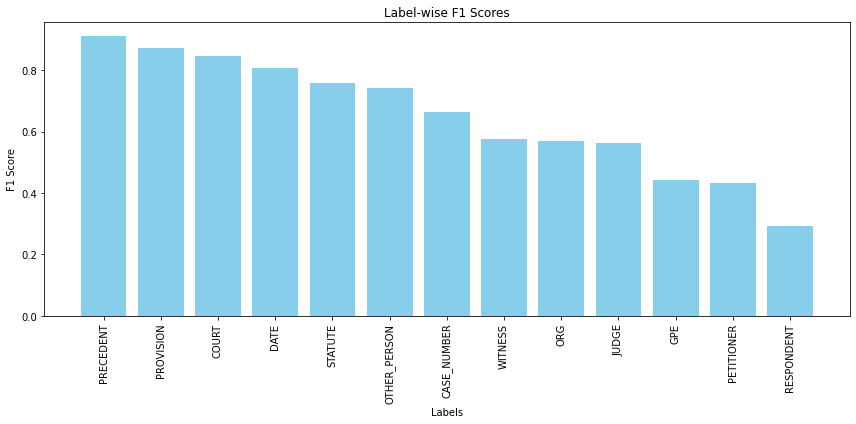

In [25]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def plot_labelwise_f1_scores(label_dict, predicted_list, true_list):
    # Reverse the dictionary mapping to convert indexes back to labels
    index_to_label = {v: k for k, v in label_dict.items()}

    # Convert indexes to actual labels
    true_labels = [index_to_label[idx] for idx in true_list]
    predicted_labels = [index_to_label[idx] for idx in predicted_list]

    # Remove the B- and I- prefixes from the labels
    true_labels_stripped = [label[2:] if label.startswith(('B_', 'I_')) else label for label in true_labels]
    predicted_labels_stripped = [label[2:] if label.startswith(('B_', 'I_')) else label for label in predicted_labels]

    # Remove 'O' label if present
    unique_labels_stripped = list(set(true_labels_stripped + predicted_labels_stripped))
    unique_labels_stripped.remove('O') if 'O' in unique_labels_stripped else None

    # Calculate F1 scores for each unique label
    f1_scores = f1_score(true_labels_stripped, predicted_labels_stripped, labels=unique_labels_stripped, average=None)

    # Create a mapping of labels to their F1 scores
    label_f1_scores = dict(zip(unique_labels_stripped, f1_scores))

    # Sort labels by F1 score
    sorted_labels = sorted(label_f1_scores, key=label_f1_scores.get, reverse=True)
    sorted_f1_scores = [label_f1_scores[label] for label in sorted_labels]

    # Plot the F1 scores
    plt.figure(figsize=(12, 6))
    plt.bar(sorted_labels, sorted_f1_scores, color='skyblue')
    plt.xlabel('Labels')
    plt.ylabel('F1 Score')
    plt.title('Label-wise F1 Scores')
    plt.xticks(rotation=90)  # Rotate labels to prevent overlap
    plt.tight_layout()  # Adjust layout to fit all label names
    plt.show()

print("For Word2Vec: ")
plot_labelwise_f1_scores(labels_to_index_bilstmcrf_word2vec, test_preds_bilstmcrf_word2vec_task1, test_true_bilstmcrf_word2vec_task1) 


For GLoVe: 


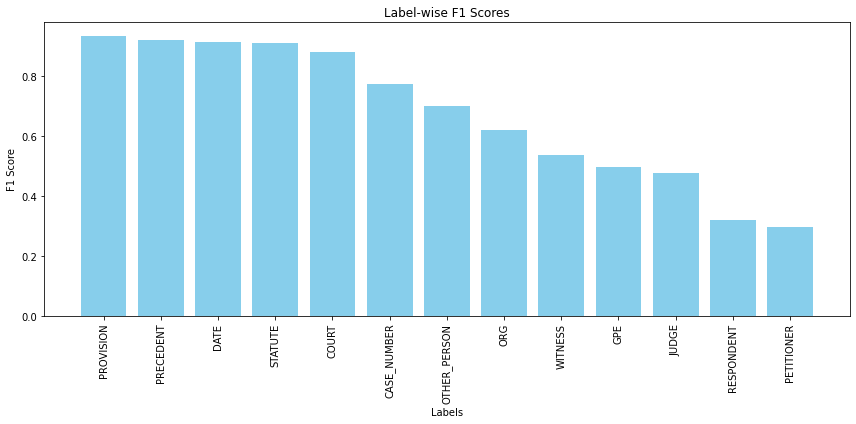

In [26]:
print("For GLoVe: ")
plot_labelwise_f1_scores(labels_to_index_bilstmcrf_glove, test_preds_bilstmcrf_glove_task1, test_true_bilstmcrf_glove_task1)

For Fasttext: 


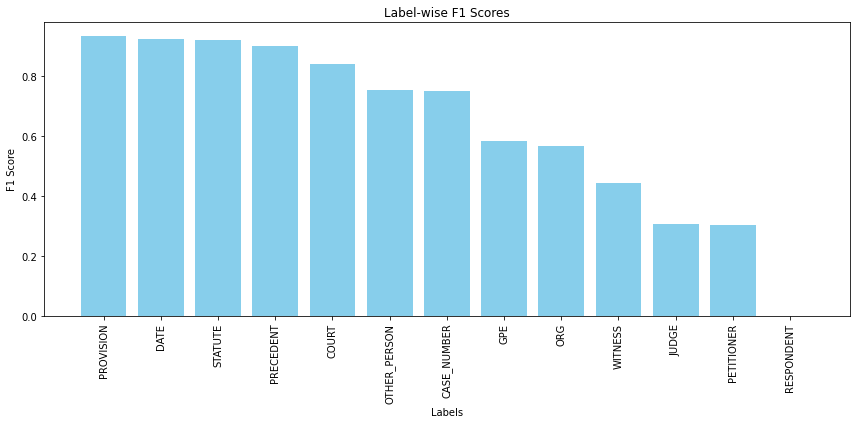

In [27]:
print("For Fasttext: ")
plot_labelwise_f1_scores(labels_to_index_bilstmcrf_fasttext, test_preds_bilstmcrf_fasttext_task1, test_true_bilstmcrf_fasttext_task1) 

In [28]:
# Delete the models and the dataloaders
del model_fasttext_bilstmcrf_task1
del model_glove_bilstmcrf_task1
del model_word2vec_bilstmcrf_task1

del test_dataloader_fasttext_bilstmcrf
del test_dataloader_glove_bilstmcrf
del test_dataloader_word2vec_bilstmcrf

# Task 2 - ATE

- Loading the Pickle Files

In [29]:
# Function to load the data from the json file
def load_from_json(file_path):
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

"""
Task 2 - Embeddings
"""
fasttext_task2 = "Task2_Fasttext_test_embeddings.pkl"
glove_task2 = "Task2_GLoVe_test_embeddings.pkl"
word2vec_task2 = "Task2_Word2Vec_test_embeddings.pkl"

# Load the embeddings
fasttext_embeddings_task2 = pickle.load(open(fasttext_task2, "rb"))
glove_embeddings_task2 = pickle.load(open(glove_task2, "rb"))
word2vec_embeddings_task2 = pickle.load(open(word2vec_task2, "rb"))

# Load the test labels
test_label_path = "ATE_test_labels.json"
test_labels_task2 = load_from_json(test_label_path)

- Padding the Sequences to the Same Length

In [30]:
max_length = 83

# Padding the embeddings
for key in fasttext_embeddings_task2:
    label = test_labels_task2[key]
    embeddings_fasttext = fasttext_embeddings_task2[key]
    embeddings_glove = glove_embeddings_task2[key]
    embeddings_word2vec = word2vec_embeddings_task2[key]

    # Pad the labels
    if len(label) < max_length:
        label = label + ['O'] * (max_length - len(label))

    # Pad the embeddings
    if len(embeddings_fasttext) < max_length:
        embeddings_fasttext = np.concatenate((embeddings_fasttext, np.zeros((max_length - len(embeddings_fasttext), 300))), axis=0)
        embeddings_glove = np.concatenate((embeddings_glove, np.zeros((max_length - len(embeddings_glove), 300))), axis=0)
        embeddings_word2vec = np.concatenate((embeddings_word2vec, np.zeros((max_length - len(embeddings_word2vec), 300))), axis=0)

    # Update the 4 dictionaries
    fasttext_embeddings_task2[key] = embeddings_fasttext
    glove_embeddings_task2[key] = embeddings_glove
    word2vec_embeddings_task2[key] = embeddings_word2vec
    test_labels_task2[key] = label

# Iterate through the embeddings to check the shape of the data
for key in test_labels_task2:
        print(f"({len(test_labels_task2[key])}, {len(test_labels_task2[key][0])}), ({len(fasttext_embeddings_task2[key])}, {len(fasttext_embeddings_task2[key][0])}), ({len(glove_embeddings_task2[key])}, {len(glove_embeddings_task2[key][0])}), ({len(word2vec_embeddings_task2[key])}, {len(word2vec_embeddings_task2[key][0])})")


(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 300), (83, 300), (83, 300)
(83, 1), (83, 30

In [31]:
# Convert the embeddings to tensor
embeddings_fasttext_task2 = torch.tensor([fasttext_embeddings_task2[key] for key in fasttext_embeddings_task2], dtype=torch.float)
embeddings_glove_task2 = torch.tensor([glove_embeddings_task2[key] for key in glove_embeddings_task2], dtype=torch.float)
embeddings_word2vec_task2 = torch.tensor([word2vec_embeddings_task2[key] for key in word2vec_embeddings_task2], dtype=torch.float)

- Label to Index for all Models

In [32]:
"""
Task 2 - Labels to Index
"""

labels_to_index_rnn_fasttext_task2 = {'B': 0, 'I': 1, 'O': 2}
labels_to_index_rnn_glove_task2 = {'B': 0, 'I': 1, 'O': 2}
labels_to_index_rnn_word2vec_task2 = {'B': 0, 'O': 1, 'I': 2}

labels_to_index_lstm_fasttext_task2 =  {'B': 0, 'O': 1, 'I': 2}
labels_to_index_lstm_glove_task2 = {'I': 0, 'B': 1, 'O': 2}
labels_to_index_lstm_word2vec_task2 = {'O': 0, 'I': 1, 'B': 2}

labels_to_index_gru_fasttext_task2 = {'I': 0, 'B': 1, 'O': 2}
labels_to_index_gru_glove_task2 = {'I': 0, 'O': 1, 'B': 2}
labels_to_index_gru_word2vec_task2 = {'B': 0, 'I': 1, 'O': 2}

labels_to_index_bilstmcrf_fasttext_task2 = {'<START>': 0, '<STOP>': 1, 'I': 2, 'O': 3, 'B': 4}
labels_to_index_bilstmcrf_glove_task2 = {'O': 0, 'B': 1, '<START>': 2, '<STOP>': 3, 'I': 4}
labels_to_index_bilstmcrf_word2vec_task2 = {'I': 0, '<START>': 1, 'B': 2, 'O': 3, '<STOP>': 4}

In [33]:
# Convert labels to indices for RNN
test_labels_rnn_fasttext_task2 = labels_to_indices(test_labels_task2.values(), labels_to_index_rnn_fasttext_task2)
test_labels_rnn_glove_task2 = labels_to_indices(test_labels_task2.values(), labels_to_index_rnn_glove_task2)
test_labels_rnn_word2vec_task2 = labels_to_indices(test_labels_task2.values(), labels_to_index_rnn_word2vec_task2)

# Convert labels to tensor
test_labels_rnn_fasttext_tensor_task2 = torch.tensor(test_labels_rnn_fasttext_task2, dtype=torch.long)
test_labels_rnn_glove_tensor_task2 = torch.tensor(test_labels_rnn_glove_task2, dtype=torch.long)
test_labels_rnn_word2vec_tensor_task2 = torch.tensor(test_labels_rnn_word2vec_task2, dtype=torch.long)

# Dataloaders for RNN
test_dataset_fasttext_rnn_task2 = TensorDataset(embeddings_fasttext_task2, test_labels_rnn_fasttext_tensor_task2)
test_dataloader_fasttext_rnn_task2 = DataLoader(test_dataset_fasttext_rnn_task2, batch_size=32, shuffle=False)

test_dataset_glove_rnn_task2 = TensorDataset(embeddings_glove_task2, test_labels_rnn_glove_tensor_task2)
test_dataloader_glove_rnn_task2 = DataLoader(test_dataset_glove_rnn_task2, batch_size=32, shuffle=False)

test_dataset_word2vec_rnn_task2 = TensorDataset(embeddings_word2vec_task2, test_labels_rnn_word2vec_tensor_task2)
test_dataloader_word2vec_rnn_task2 = DataLoader(test_dataset_word2vec_rnn_task2, batch_size=32, shuffle=False)

# Iterate through dataloaders to check the shape of the data
for i, (x, y) in enumerate(test_dataloader_fasttext_rnn_task2):
    print(x.shape, y.shape)
    break

torch.Size([32, 83, 300]) torch.Size([32, 83])


### Task 2 - RNN

In [34]:
class RNNModel_Task2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel_Task2, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

In [35]:
"""
Word2Vec
"""

model_word2vec_rnn_task2 = RNNModel_Task2(input_dim=300, hidden_dim=256, output_dim=3, num_layers=1)

# Load the model
model_word2vec_rnn_task2.load_state_dict(torch.load("Task2_RNN_Word2Vec_model.pth"))

# Set the model to evaluation mode
model_word2vec_rnn_task2.eval()

# Evaluation
test_preds_rnn_word2vec_task2 = []
test_true_rnn_word2vec_task2 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_word2vec_rnn_task2:
        outputs = model_word2vec_rnn_task2(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_rnn_word2vec_task2.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_rnn_word2vec_task2.extend(labels.view(-1).numpy())  # Flatten and store true labels

# Calculate the F1-score
f1_score_rnn_word2vec_task2 = f1_score(test_true_rnn_word2vec_task2, test_preds_rnn_word2vec_task2, average='macro')

# Calculate the accuracy
accuracy_rnn_word2vec_task2 = accuracy_score(test_true_rnn_word2vec_task2, test_preds_rnn_word2vec_task2)

print(f"Task2 - RNN Word2Vec - F1: {f1_score_rnn_word2vec_task2}")
print(f"Task2 - RNN Word2Vec - Accuracy: {accuracy_rnn_word2vec_task2}")

"""
GloVe
"""

model_glove_rnn_task2 = RNNModel_Task2(input_dim=300, hidden_dim=256, output_dim=3, num_layers=1)

# Load the model
model_glove_rnn_task2.load_state_dict(torch.load("Task2_RNN_GloVe_model.pth"))

# Set the model to evaluation mode
model_glove_rnn_task2.eval()

# Evaluation
test_preds_rnn_glove_task2 = []
test_true_rnn_glove_task2 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_glove_rnn_task2:
        outputs = model_glove_rnn_task2(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_rnn_glove_task2.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_rnn_glove_task2.extend(labels.view(-1).numpy())  # Flatten and store true labels

# Calculate the F1-score
f1_score_rnn_glove_task2 = f1_score(test_true_rnn_glove_task2, test_preds_rnn_glove_task2, average='macro')

# Calculate the accuracy
accuracy_rnn_glove_task2 = accuracy_score(test_true_rnn_glove_task2, test_preds_rnn_glove_task2)

print(f"Task2 - RNN GLoVe - F1: {f1_score_rnn_glove_task2}")
print(f"Task2 - RNN GLoVe - Accuracy: {accuracy_rnn_glove_task2}")

"""
Fasttext
"""

model_fasttext_rnn_task2 = RNNModel_Task2(input_dim=300, hidden_dim=256, output_dim=3, num_layers=1)

# Load the model
model_fasttext_rnn_task2.load_state_dict(torch.load("Task2_RNN_FastText_model.pth"))

# Set the model to evaluation mode
model_fasttext_rnn_task2.eval()

# Evaluation
test_preds_rnn_fasttext_task2 = []
test_true_rnn_fasttext_task2 = []

with torch.no_grad():  # Do not compute gradients 
    for inputs, labels in test_dataloader_fasttext_rnn_task2:
        outputs = model_fasttext_rnn_task2(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_rnn_fasttext_task2.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_rnn_fasttext_task2.extend(labels.view(-1).numpy())  # Flatten and store true labels

# Calculate the F1-score
f1_score_rnn_fasttext_task2 = f1_score(test_true_rnn_fasttext_task2, test_preds_rnn_fasttext_task2, average='macro')

# Calculate the accuracy
accuracy_rnn_fasttext_task2 = accuracy_score(test_true_rnn_fasttext_task2, test_preds_rnn_fasttext_task2)

print(f"Task2 - RNN Fasttext - F1: {f1_score_rnn_fasttext_task2}")
print(f"Task2 - RNN Fasttext - Accuracy: {accuracy_rnn_fasttext_task2}")

Task2 - RNN Word2Vec - F1: 0.7390856301123915
Task2 - RNN Word2Vec - Accuracy: 0.9851601528063474
Task2 - RNN GLoVe - F1: 0.7929509870722535
Task2 - RNN GLoVe - Accuracy: 0.9868131060828681
Task2 - RNN Fasttext - F1: 0.5638986815562818
Task2 - RNN Fasttext - Accuracy: 0.9779973552747576


In [36]:
# Delete the models and the dataloaders
del model_fasttext_rnn_task2
del model_glove_rnn_task2
del model_word2vec_rnn_task2

del test_dataloader_fasttext_rnn_task2
del test_dataloader_glove_rnn_task2
del test_dataloader_word2vec_rnn_task2

### Task 2 - GLoVe

In [37]:
# Define the LSTM model
class LSTMModel_Task2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMModel_Task2, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)  # Take the output of the last timestep
        return out

In [38]:
# Convert labels to indices for LSTM
test_labels_lstm_fasttext_task2 = labels_to_indices(test_labels_task2.values(), labels_to_index_lstm_fasttext_task2)
test_labels_lstm_glove_task2 = labels_to_indices(test_labels_task2.values(), labels_to_index_lstm_glove_task2)
test_labels_lstm_word2vec_task2 = labels_to_indices(test_labels_task2.values(), labels_to_index_lstm_word2vec_task2)

# Convert labels to tensor
test_labels_lstm_fasttext_tensor_task2 = torch.tensor(test_labels_lstm_fasttext_task2, dtype=torch.long)
test_labels_lstm_glove_tensor_task2 = torch.tensor(test_labels_lstm_glove_task2, dtype=torch.long)
test_labels_lstm_word2vec_tensor_task2 = torch.tensor(test_labels_lstm_word2vec_task2, dtype=torch.long)

# Dataloaders for LSTM
test_dataset_fasttext_lstm_task2 = TensorDataset(embeddings_fasttext_task2, test_labels_lstm_fasttext_tensor_task2)
test_dataloader_fasttext_lstm_task2 = DataLoader(test_dataset_fasttext_lstm_task2, batch_size=32, shuffle=False)

test_dataset_glove_lstm_task2 = TensorDataset(embeddings_glove_task2, test_labels_lstm_glove_tensor_task2)
test_dataloader_glove_lstm_task2 = DataLoader(test_dataset_glove_lstm_task2, batch_size=32, shuffle=False)

test_dataset_word2vec_lstm_task2 = TensorDataset(embeddings_word2vec_task2, test_labels_lstm_word2vec_tensor_task2)
test_dataloader_word2vec_lstm_task2 = DataLoader(test_dataset_word2vec_lstm_task2, batch_size=32, shuffle=False)

# Iterate through dataloaders to check the shape of the data
for i, (x, y) in enumerate(test_dataloader_fasttext_lstm_task2):
    print(x.shape, y.shape)
    break

torch.Size([32, 83, 300]) torch.Size([32, 83])


In [39]:
"""For Word2Vec"""

model_word2vec_lstm_task2 = LSTMModel_Task2(input_dim=300, hidden_dim=256, output_dim=3, num_layers=1, dropout=0)

# Load the model
model_word2vec_lstm_task2.load_state_dict(torch.load("Task2_LSTM_Word2Vec_model.pth"))

# Set the model to evaluation mode
model_word2vec_lstm_task2.eval()

# Evaluation
test_preds_lstm_word2vec_task2 = []
test_true_lstm_word2vec_task2 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_word2vec_lstm_task2:
        outputs = model_word2vec_lstm_task2(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_lstm_word2vec_task2.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_lstm_word2vec_task2.extend(labels.view(-1).numpy())  # Flatten and store true labels

# Calculate the F1-score
f1_score_lstm_word2vec_task2 = f1_score(test_true_lstm_word2vec_task2, test_preds_lstm_word2vec_task2, average='macro')

# Calculate the accuracy
accuracy_lstm_word2vec_task2 = accuracy_score(test_true_lstm_word2vec_task2, test_preds_lstm_word2vec_task2)

print(f"Task2 - LSTM Word2Vec - F1: {f1_score_lstm_word2vec_task2}")
print(f"Task2 - LSTM Word2Vec - Accuracy: {accuracy_lstm_word2vec_task2}")

"""For GLoVe"""

model_glove_lstm_task2 = LSTMModel_Task2(input_dim=300, hidden_dim=256, output_dim=3, num_layers=1, dropout=0)

# Load the model
model_glove_lstm_task2.load_state_dict(torch.load("Task2_LSTM_GloVe_model.pth"))

# Set the model to evaluation mode
model_glove_lstm_task2.eval()

# Evaluation
test_preds_lstm_glove_task2 = []
test_true_lstm_glove_task2 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_glove_lstm_task2:
        outputs = model_glove_lstm_task2(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_lstm_glove_task2.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_lstm_glove_task2.extend(labels.view(-1).numpy())  # Flatten and store true labels

# Calculate the F1-score
f1_score_lstm_glove_task2 = f1_score(test_true_lstm_glove_task2, test_preds_lstm_glove_task2, average='macro')

# Calculate the accuracy
accuracy_lstm_glove_task2 = accuracy_score(test_true_lstm_glove_task2, test_preds_lstm_glove_task2)

print(f"Task2 - LSTM GLoVe - F1: {f1_score_lstm_glove_task2}")
print(f"Task2 - LSTM GLoVe - Accuracy: {accuracy_lstm_glove_task2}")

"""For Fasttext"""

model_fasttext_lstm_task2 = LSTMModel_Task2(input_dim=300, hidden_dim=256, output_dim=3, num_layers=1, dropout=0)

# Load the model
model_fasttext_lstm_task2.load_state_dict(torch.load("Task2_LSTM_Fasttext_model.pth"))

# Set the model to evaluation mode
model_fasttext_lstm_task2.eval()

# Evaluation
test_preds_lstm_fasttext_task2 = []
test_true_lstm_fasttext_task2 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_fasttext_lstm_task2:
        outputs = model_fasttext_lstm_task2(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_lstm_fasttext_task2.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_lstm_fasttext_task2.extend(labels.view(-1).numpy())  # Flatten and store true labels

# Calculate the F1-score
f1_score_lstm_fasttext_task2 = f1_score(test_true_lstm_fasttext_task2, test_preds_lstm_fasttext_task2, average='macro')

# Calculate the accuracy
accuracy_lstm_fasttext_task2 = accuracy_score(test_true_lstm_fasttext_task2, test_preds_lstm_fasttext_task2)

print(f"Task2 - LSTM Fasttext - F1: {f1_score_lstm_fasttext_task2}")
print(f"Task2 - LSTM Fasttext - Accuracy: {accuracy_lstm_fasttext_task2}")

Task2 - LSTM Word2Vec - F1: 0.7342678975895388
Task2 - LSTM Word2Vec - Accuracy: 0.985049955921246
Task2 - LSTM GLoVe - F1: 0.7813560882766556
Task2 - LSTM GLoVe - Accuracy: 0.9864825154275639
Task2 - LSTM Fasttext - F1: 0.5971760537214629
Task2 - LSTM Fasttext - Accuracy: 0.9801645606817514


In [40]:
# Delete the models and the dataloaders
del model_fasttext_lstm_task2
del model_glove_lstm_task2
del model_word2vec_lstm_task2

del test_dataloader_fasttext_lstm_task2
del test_dataloader_glove_lstm_task2
del test_dataloader_word2vec_lstm_task2

### Task 2 - GRU

In [41]:
# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out)  # Take the output of the last timestep
        return out

In [42]:
# Convert labels to indices for GRU
test_labels_gru_fasttext_task2 = labels_to_indices(test_labels_task2.values(), labels_to_index_gru_fasttext_task2)
test_labels_gru_glove_task2 = labels_to_indices(test_labels_task2.values(), labels_to_index_gru_glove_task2)
test_labels_gru_word2vec_task2 = labels_to_indices(test_labels_task2.values(), labels_to_index_gru_word2vec_task2)

# Convert labels to tensor
test_labels_gru_fasttext_tensor_task2 = torch.tensor(test_labels_gru_fasttext_task2, dtype=torch.long)
test_labels_gru_glove_tensor_task2 = torch.tensor(test_labels_gru_glove_task2, dtype=torch.long)
test_labels_gru_word2vec_tensor_task2 = torch.tensor(test_labels_gru_word2vec_task2, dtype=torch.long)

# Dataloaders for GRU
test_dataset_fasttext_gru_task2 = TensorDataset(embeddings_fasttext_task2, test_labels_gru_fasttext_tensor_task2)
test_dataloader_fasttext_gru_task2 = DataLoader(test_dataset_fasttext_gru_task2, batch_size=32, shuffle=False)

test_dataset_glove_gru_task2 = TensorDataset(embeddings_glove_task2, test_labels_gru_glove_tensor_task2)
test_dataloader_glove_gru_task2 = DataLoader(test_dataset_glove_gru_task2, batch_size=32, shuffle=False)

test_dataset_word2vec_gru_task2 = TensorDataset(embeddings_word2vec_task2, test_labels_gru_word2vec_tensor_task2)
test_dataloader_word2vec_gru_task2 = DataLoader(test_dataset_word2vec_gru_task2, batch_size=32, shuffle=False)

# Iterate through dataloaders to check the shape of the data
for i, (x, y) in enumerate(test_dataloader_fasttext_gru_task2):
    print(x.shape, y.shape)
    break

torch.Size([32, 83, 300]) torch.Size([32, 83])


In [43]:
"""For Word2Vec"""

model_word2vec_gru_task2 = GRUModel(input_dim=300, hidden_dim=256, output_dim=3, num_layers=1, dropout=0)

# Load the model
model_word2vec_gru_task2.load_state_dict(torch.load("Task2_GRU_Word2Vec_model.pth"))

# Set the model to evaluation mode
model_word2vec_gru_task2.eval()

# Evaluation
test_preds_gru_word2vec_task2 = []
test_true_gru_word2vec_task2 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_word2vec_gru_task2:
        outputs = model_word2vec_gru_task2(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_gru_word2vec_task2.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_gru_word2vec_task2.extend(labels.view(-1).numpy())  # Flatten and store true labels

# Calculate the F1-score
f1_score_gru_word2vec_task2 = f1_score(test_true_gru_word2vec_task2, test_preds_gru_word2vec_task2, average='macro')

# Calculate the accuracy
accuracy_gru_word2vec_task2 = accuracy_score(test_true_gru_word2vec_task2, test_preds_gru_word2vec_task2)

print(f"Task2 - GRU Word2Vec - F1: {f1_score_gru_word2vec_task2}")
print(f"Task2 - GRU Word2Vec - Accuracy: {accuracy_gru_word2vec_task2}")

"""For GLoVe"""

model_glove_gru_task2 = GRUModel(input_dim=300, hidden_dim=256, output_dim=3, num_layers=1, dropout=0)

# Load the model
model_glove_gru_task2.load_state_dict(torch.load("Task2_GRU_GloVe_model.pth"))

# Set the model to evaluation mode
model_glove_gru_task2.eval()

# Evaluation
test_preds_gru_glove_task2 = []
test_true_gru_glove_task2 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_glove_gru_task2:
        outputs = model_glove_gru_task2(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_gru_glove_task2.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_gru_glove_task2.extend(labels.view(-1).numpy())  # Flatten and store true labels

# Calculate the F1-score
f1_score_gru_glove_task2 = f1_score(test_true_gru_glove_task2, test_preds_gru_glove_task2, average='macro')

# Calculate the accuracy
accuracy_gru_glove_task2 = accuracy_score(test_true_gru_glove_task2, test_preds_gru_glove_task2)

print(f"Task2 - GRU GLoVe - F1: {f1_score_gru_glove_task2}")
print(f"Task2 - GRU GLoVe - Accuracy: {accuracy_gru_glove_task2}")

"""For Fasttext"""

model_fasttext_gru_task2 = GRUModel(input_dim=300, hidden_dim=256, output_dim=3, num_layers=1, dropout=0)

# Load the model
model_fasttext_gru_task2.load_state_dict(torch.load("Task2_GRU_Fasttext_model.pth"))

# Set the model to evaluation mode
model_fasttext_gru_task2.eval()

# Evaluation
test_preds_gru_fasttext_task2 = []
test_true_gru_fasttext_task2 = []

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_dataloader_fasttext_gru_task2:
        outputs = model_fasttext_gru_task2(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds_gru_fasttext_task2.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true_gru_fasttext_task2.extend(labels.view(-1).numpy())  # Flatten and store true labels

# Calculate the F1-score
f1_score_gru_fasttext_task2 = f1_score(test_true_gru_fasttext_task2, test_preds_gru_fasttext_task2, average='macro')

# Calculate the accuracy
accuracy_gru_fasttext_task2 = accuracy_score(test_true_gru_fasttext_task2, test_preds_gru_fasttext_task2)

print(f"Task2 - GRU Fasttext - F1: {f1_score_gru_fasttext_task2}")
print(f"Task2 - GRU Fasttext - Accuracy: {accuracy_gru_fasttext_task2}")

Task2 - GRU Word2Vec - F1: 0.789032773905856
Task2 - GRU Word2Vec - Accuracy: 0.9864825154275639
Task2 - GRU GLoVe - F1: 0.8099840106802813
Task2 - GRU GLoVe - Accuracy: 0.9875844842785777
Task2 - GRU Fasttext - F1: 0.7181476427826373
Task2 - GRU Fasttext - Accuracy: 0.9837275933000293


In [44]:
# Delete the models and the dataloaders
del model_fasttext_gru_task2
del model_glove_gru_task2
del model_word2vec_gru_task2

del test_dataloader_fasttext_gru_task2
del test_dataloader_glove_gru_task2
del test_dataloader_word2vec_gru_task2

### Task 2 - BiLSTM-CRF (Part 2)

In [45]:
"""
Helper functions to train the model
"""
START_TAG = "<START>"
STOP_TAG = "<STOP>"

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, tag_to_ix, embedding_dim, hidden_dim, batch_size):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.tag_to_ix = tag_to_ix
        self.batch_size = batch_size
        self.tagset_size = len(tag_to_ix)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000


    def init_hidden(self, batch_size):
        num_layers = 2 if self.lstm.bidirectional else 1
        return (torch.randn(num_layers, batch_size, self.hidden_dim // 2),
            torch.randn(num_layers, batch_size, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, embeds):
        hidden = self.init_hidden(batch_size=embeds.shape[0])
        embeds = embeds.permute(1, 0, 2)

        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.permute(1, 0, 2).contiguous().view(-1, self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = tags.view(-1) # flatten the tags
        #print(torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).shape)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags], dim=0)
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, embeddings, tags):
        feats = self._get_lstm_features(embeds=embeddings)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [46]:
# Convert labels to indices for BiLSTM-CRF
test_labels_bilstmcrf_fasttext_task2 = labels_to_indices(test_labels_task2.values(), labels_to_index_bilstmcrf_fasttext_task2)
test_labels_bilstmcrf_glove_task2 = labels_to_indices(test_labels_task2.values(), labels_to_index_bilstmcrf_glove_task2)
test_labels_bilstmcrf_word2vec_task2 = labels_to_indices(test_labels_task2.values(), labels_to_index_bilstmcrf_word2vec_task2)

# Convert labels to tensor
test_labels_bilstmcrf_fasttext_tensor_task2 = torch.tensor(test_labels_bilstmcrf_fasttext_task2, dtype=torch.long)
test_labels_bilstmcrf_glove_tensor_task2 = torch.tensor(test_labels_bilstmcrf_glove_task2, dtype=torch.long)
test_labels_bilstmcrf_word2vec_tensor_task2 = torch.tensor(test_labels_bilstmcrf_word2vec_task2, dtype=torch.long)

# Dataloaders for BiLSTM-CRF
test_dataset_fasttext_bilstmcrf_task2 = TensorDataset(embeddings_fasttext_task2, test_labels_bilstmcrf_fasttext_tensor_task2)
test_dataloader_fasttext_bilstmcrf_task2 = DataLoader(test_dataset_fasttext_bilstmcrf_task2, batch_size=1, shuffle=False)

test_dataset_glove_bilstmcrf_task2 = TensorDataset(embeddings_glove_task2, test_labels_bilstmcrf_glove_tensor_task2)
test_dataloader_glove_bilstmcrf_task2 = DataLoader(test_dataset_glove_bilstmcrf_task2, batch_size=1, shuffle=False)

test_dataset_word2vec_bilstmcrf_task2 = TensorDataset(embeddings_word2vec_task2, test_labels_bilstmcrf_word2vec_tensor_task2)
test_dataloader_word2vec_bilstmcrf_task2 = DataLoader(test_dataset_word2vec_bilstmcrf_task2, batch_size=1, shuffle=False)

# Iterate through dataloaders to check the shape of the data
for i, (x, y) in enumerate(test_dataloader_fasttext_bilstmcrf_task2):
    print(x.shape, y.shape)
    break

torch.Size([1, 83, 300]) torch.Size([1, 83])


In [47]:
"""For Word2Vec"""

model_word2vec_bilstmcrf_task2 = BiLSTM_CRF(tag_to_ix=labels_to_index_bilstmcrf_word2vec_task2, embedding_dim=300, hidden_dim=256, batch_size=1)

# Load the model
model_word2vec_bilstmcrf_task2.load_state_dict(torch.load("Task2_BiLSTMCRF_Word2Vec.pt"))

# Evaluation
test_preds_bilstmcrf_word2vec_task2 = []
test_true_bilstmcrf_word2vec_task2 = []

with torch.no_grad():
    for i, (embeddings, labels) in enumerate(test_dataloader_word2vec_bilstmcrf_task2):
        # Run forward pass
        _, predicted = model_word2vec_bilstmcrf_task2(embeddings)
        predicted = torch.tensor(predicted, dtype=torch.long)
        labels = labels.view(-1)
        predicted = predicted.view(-1)

        # Append the predictions and true labels
        test_preds_bilstmcrf_word2vec_task2.extend(predicted.tolist())
        test_true_bilstmcrf_word2vec_task2.extend(labels.tolist())

# Calculate the F1-score
f1_score_bilstmcrf_word2vec_task2 = f1_score(test_true_bilstmcrf_word2vec_task2, test_preds_bilstmcrf_word2vec_task2, average='macro')

# Calculate the accuracy
accuracy_bilstmcrf_word2vec_task2 = accuracy_score(test_true_bilstmcrf_word2vec_task2, test_preds_bilstmcrf_word2vec_task2)

print(f"Task2 - BiLSTM-CRF Word2Vec - F1: {f1_score_bilstmcrf_word2vec_task2}")
print(f"Task2 - BiLSTM-CRF Word2Vec - Accuracy: {accuracy_bilstmcrf_word2vec_task2}")

Task2 - BiLSTM-CRF Word2Vec - F1: 0.7933406056758345
Task2 - BiLSTM-CRF Word2Vec - Accuracy: 0.9868131060828681


In [48]:
"""Glove"""

model_glove_bilstmcrf_task2 = BiLSTM_CRF(tag_to_ix=labels_to_index_bilstmcrf_glove_task2, embedding_dim=300, hidden_dim=256, batch_size=1)

# Load the model
model_glove_bilstmcrf_task2.load_state_dict(torch.load("Task2_BiLSTMCRF_Glove.pt"))

# Evaluation
test_preds_bilstmcrf_glove_task2 = []
test_true_bilstmcrf_glove_task2 = []

with torch.no_grad():
    for i, (embeddings, labels) in enumerate(test_dataloader_glove_bilstmcrf_task2):
        # Run forward pass
        _, predicted = model_glove_bilstmcrf_task2(embeddings)
        predicted = torch.tensor(predicted, dtype=torch.long)
        labels = labels.view(-1)
        predicted = predicted.view(-1)

        # Append the predictions and true labels
        test_preds_bilstmcrf_glove_task2.extend(predicted.tolist())
        test_true_bilstmcrf_glove_task2.extend(labels.tolist())

# Calculate the F1-score
f1_score_bilstmcrf_glove_task2 = f1_score(test_true_bilstmcrf_glove_task2, test_preds_bilstmcrf_glove_task2, average='macro')

# Calculate the accuracy
accuracy_bilstmcrf_glove_task2 = accuracy_score(test_true_bilstmcrf_glove_task2, test_preds_bilstmcrf_glove_task2)

print(f"Task2 - BiLSTM-CRF GLOVE - F1: {f1_score_bilstmcrf_glove_task2}")
print(f"Task2 - BiLSTM-CRF GLOVE - Accuracy: {accuracy_bilstmcrf_glove_task2}")

"""Fasttext"""

model_fasttext_bilstmcrf_task2 = BiLSTM_CRF(tag_to_ix=labels_to_index_bilstmcrf_fasttext_task2, embedding_dim=300, hidden_dim=256, batch_size=1)

# Load the model
model_fasttext_bilstmcrf_task2.load_state_dict(torch.load("Task2_BiLSTMCRF_Fasttext.pt"))

# Evaluation
test_preds_bilstmcrf_fasttext_task2 = []
test_true_bilstmcrf_fasttext_task2 = []

with torch.no_grad():
    for i, (embeddings, labels) in enumerate(test_dataloader_fasttext_bilstmcrf_task2):
        # Run forward pass
        _, predicted = model_fasttext_bilstmcrf_task2(embeddings)
        predicted = torch.tensor(predicted, dtype=torch.long)
        labels = labels.view(-1)
        predicted = predicted.view(-1)

        # Append the predictions and true labels
        test_preds_bilstmcrf_fasttext_task2.extend(predicted.tolist())
        test_true_bilstmcrf_fasttext_task2.extend(labels.tolist())

# Calculate the F1-score
f1_score_bilstmcrf_fasttext_task2 = f1_score(test_true_bilstmcrf_fasttext_task2, test_preds_bilstmcrf_fasttext_task2, average='macro')

# Calculate the accuracy
accuracy_bilstmcrf_fasttext_task2 = accuracy_score(test_true_bilstmcrf_fasttext_task2, test_preds_bilstmcrf_fasttext_task2)

print(f"Task2 - BiLSTM-CRF Fasttext - F1: {f1_score_bilstmcrf_fasttext_task2}")
print(f"Task2 - BiLSTM-CRF Fasttext - Accuracy: {accuracy_bilstmcrf_fasttext_task2}")

Task2 - BiLSTM-CRF GLOVE - F1: 0.8351154940267326
Task2 - BiLSTM-CRF GLOVE - Accuracy: 0.9892374375550984
Task2 - BiLSTM-CRF Fasttext - F1: 0.8031410157889162
Task2 - BiLSTM-CRF Fasttext - Accuracy: 0.9861886570672935


In [ ]:
# Delete the models and the dataloaders
del model_fasttext_bilstmcrf_task2
del model_glove_bilstmcrf_task2
del model_word2vec_bilstmcrf_task2

del test_dataloader_fasttext_bilstmcrf_task2
del test_dataloader_glove_bilstmcrf_task2
del test_dataloader_word2vec_bilstmcrf_task2